In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image
import shutil as shb
import keras
from keras import layers
from keras.optimizers import Adam
from keras import ops
import datetime
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
import math
import albumentations as A
print("done importing")

2024-06-23 18:34:06.434544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 18:34:06.434680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 18:34:06.575049: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


done importing


In [2]:
data = tf.keras.utils.image_dataset_from_directory('/kaggle/input/data-for-pneumothorax/all_data',
                                                   batch_size=16,
                                                   image_size=(224, 224))

Found 13158 files belonging to 2 classes.


In [3]:
print(data)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [4]:
total_batches = tf.data.experimental.cardinality(data).numpy()
print("Total number of batches:", total_batches)
 

Total number of batches: 823


Images shape: (16, 224, 224, 3)
Labels shape: (16,)


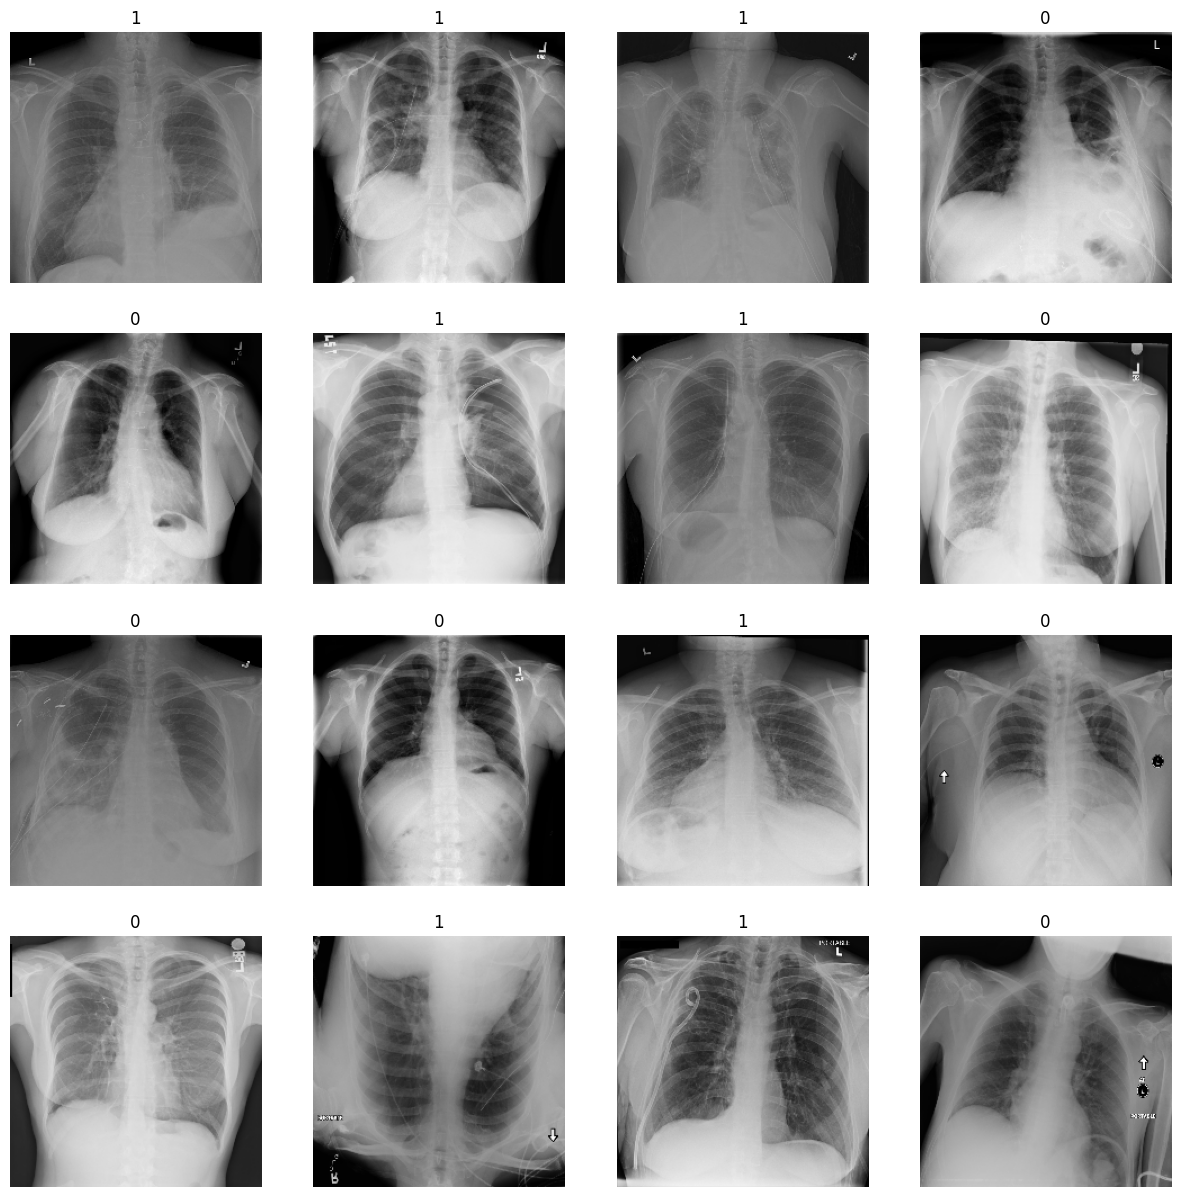

In [5]:
for images, labels in data.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    
    # Calculate the grid size
    batch_size = images.shape[0]
    grid_size = int(batch_size ** 0.5)
    grid_size = grid_size if grid_size * grid_size == batch_size else grid_size + 1

    # Display all images in the batch
    plt.figure(figsize=(15, 15))
    for i in range(batch_size):
        ax = plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    plt.show()


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
data_iterator

Images shape: (16, 224, 224, 3)
Labels shape: (16,)


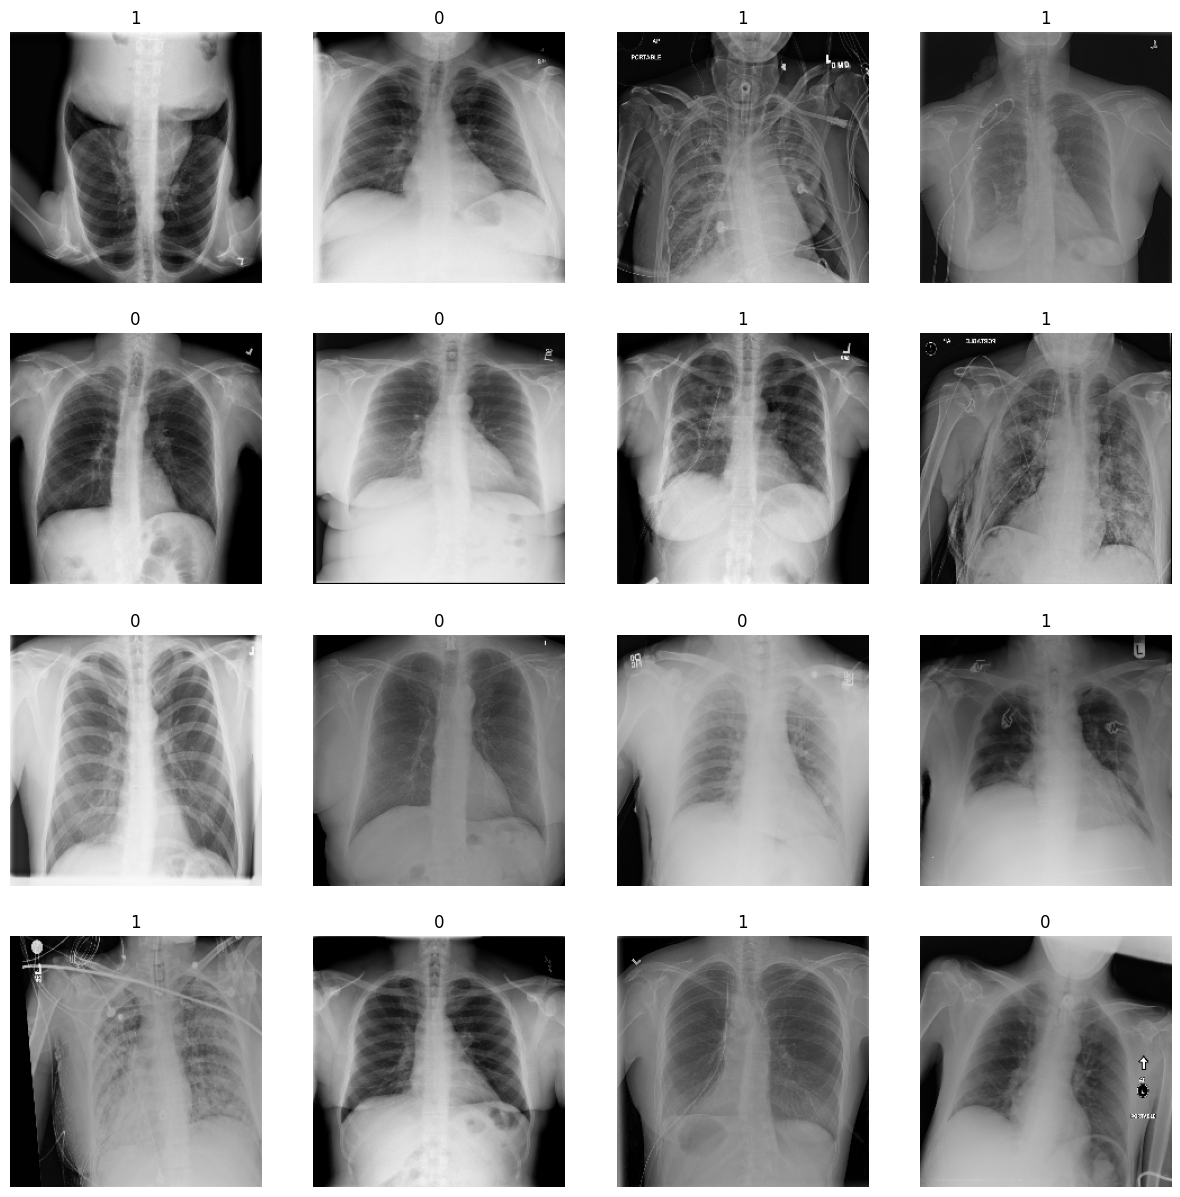

In [8]:
images, labels = next(data_iterator)

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display all images in the batch
plt.figure(figsize=(15, 15))
for i in range(images.shape[0]):
    ax = plt.subplot(4, 4, i + 1)  # Assuming batch_size is 16, so 4x4 grid
    plt.imshow(images[i].astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")
plt.show()


In [9]:
batch = data_iterator.next()

In [10]:
images, labels = batch

print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (16, 224, 224, 3)
Labels shape: (16,)


In [11]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.1)
test_size = int(len(data)*0.2)

In [12]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [13]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 3.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)


In [14]:
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [15]:

from keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from keras.callbacks import LearningRateScheduler
from keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization


def create_chexnet(input_size=(224,224)):
    """
    chexnet_weights: weights value in .h5 format of chexnet
    creates a chexnet model with preloaded weights present in chexnet_weights file
    """
    model = tf.keras.applications.DenseNet121(include_top=False,input_shape = input_size+(3,), weights=None) #importing densenet the last layer will be a relu activation layer

    #we need to load the weights so setting the architecture of the model as same as the one of the chexnet
    x = model.output #output from chexnet
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation="sigmoid", name="chexnet_output")(x) #here activation is sigmoid as seen in research paper

    chexnet = tf.keras.Model(inputs = model.input,outputs = x)
#     chexnet.load_weights(chexnet_weights)
#     chexnet = tf.keras.Model(inputs = model.input,outputs = chexnet.output)  #we will be taking the 3rd last layer (here it is layer before global avgpooling)
    #since we are using attention here
    return chexnet

In [16]:
model = create_chexnet()
model.compile(optimizer=Adam(),loss = 'binary_crossentropy',metrics=['accuracy'])

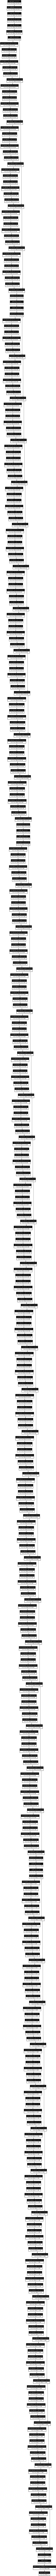

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='chexnet_model.png', show_shapes=True, show_layer_names=True)


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,038,529 (26.85 MB)

 Trainable params: 6,954,881 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [11]:
hist = model.fit(
    train,
    epochs=15,
    validation_data=val,
    callbacks=callbacks_list
)

Epoch 1/15


I0000 00:00:1716923739.180718     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


576/576 ━━━━━━━━━━━━━━━━━━━━ 322s 297ms/step - accuracy: 0.6562 - loss: 0.6003 - val_accuracy: 0.7127 - val_loss: 0.5366 - learning_rate: 0.0010
Epoch 2/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 151s 261ms/step - accuracy: 0.7044 - loss: 0.5376 - val_accuracy: 0.6966 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 3/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 150s 258ms/step - accuracy: 0.7615 - loss: 0.4750 - val_accuracy: 0.5922 - val_loss: 0.9958 - learning_rate: 5.0000e-04
Epoch 4/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 275ms/step - accuracy: 0.8064 - loss: 0.4063 - val_accuracy: 0.6784 - val_loss: 0.7874 - learning_rate: 5.0000e-04
Epoch 5/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 275ms/step - accuracy: 0.8226 - loss: 0.3827 - val_accuracy: 0.8262 - val_loss: 0.3638 - learning_rate: 5.0000e-04
Epoch 6/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 275ms/step - accuracy: 0.8421 - loss: 0.3499 - val_accuracy: 0.8041 - val_loss: 0.4088 - learning_rate: 2.5000e-04
Epoch 7/15
576/576 ━━━━━━━━━━━━━━━━━━━━ 159s 275ms/step - a

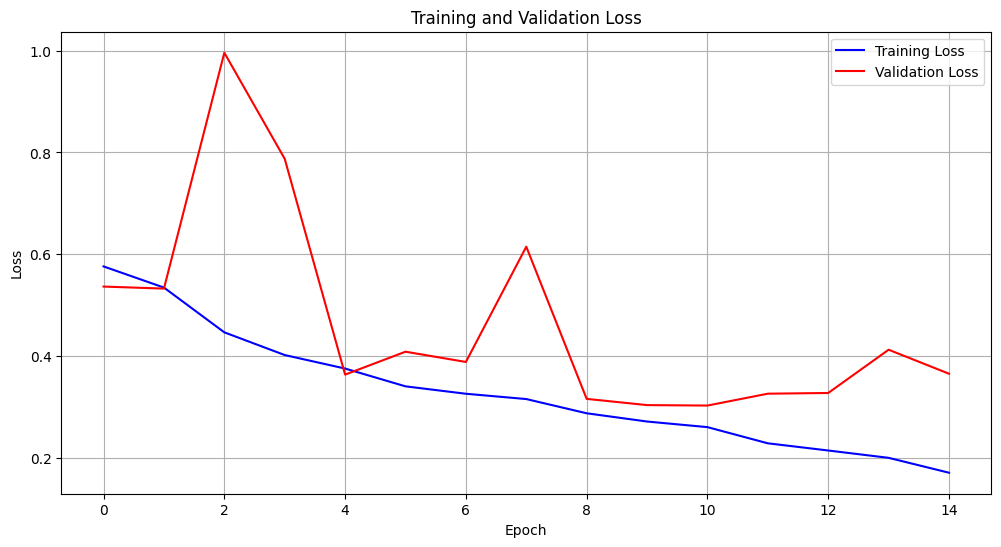

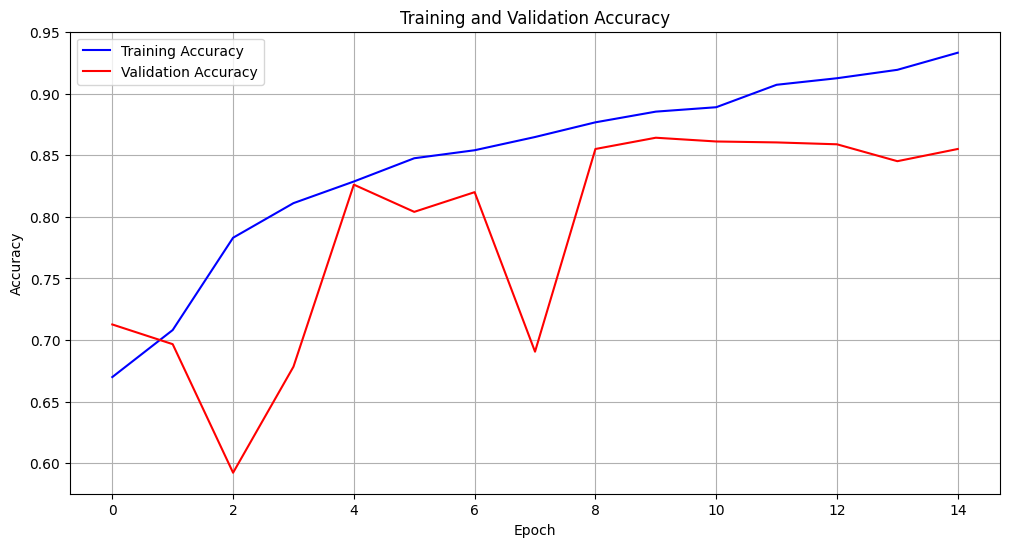

In [14]:
import matplotlib.pyplot as plt
# Extracting training history
train_loss = hist.history['loss']
train_acc = hist.history['accuracy']
val_loss = hist.history['val_loss']
val_acc = hist.history['val_accuracy']
# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Initialize counters for correct and wrong predictions
correct_predictions = 0
wrong_predictions = 0
# Set the range of indices
start_index = 0
end_index = len(test)
test_iterator = test.as_numpy_iterator()
c_o = 0
c_l = 0
for image, ground_truth_label in test_iterator:
    # Make prediction on the batch of images
    predicted_probs = model.predict(image)
    # Convert predicted probabilities to binary predictions
    predicted_labels = (predicted_probs > 0.5).astype(int)
    # Compare predicted labels with ground truth labels
    for i in range(len(ground_truth_label)):
        if predicted_labels[i][0] == ground_truth_label[i]:
            correct_predictions += 1
            if predicted_labels[i][0] == 0:
                c_o += 1
            if predicted_labels[i][0] == 1:
                c_l += 1
        else:
            wrong_predictions += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [45]:

# Initialize lists to store the coordinates and colors for the scatter plot
x_coords = []
y_coords = []
colors = []

# Initialize counters for correct and wrong predictions
correct_predictions = 0
wrong_predictions = 0
c_o = 0
c_l = 0

# Get the total number of batches in the test dataset
total_batches = tf.data.experimental.cardinality(test).numpy()

# Create a test iterator
test_iterator = test.as_numpy_iterator()

# Iterate over the test dataset
for batch_index in range(total_batches):
    # Get one batch of data
    images, ground_truth_labels = next(test_iterator)
    
    # Make prediction on the batch of images
    predicted_probs = model.predict(images)
    
    # Convert predicted probabilities to binary predictions
    predicted_labels = (predicted_probs > 0.5).astype(int)
    
    # Compare predicted labels with ground truth labels and prepare for plotting
    for i in range(len(ground_truth_labels)):
        x_coords.append(batch_index * len(ground_truth_labels) + i)
        y_coords.append(predicted_probs[i][0])
        
        if predicted_labels[i][0] == ground_truth_labels[i]:
            
            correct_predictions += 1
            if predicted_labels[i][0] == 0:
                colors.append('red')
                c_o += 1
            if predicted_labels[i][0] == 1:
                colors.append('green')
                c_l += 1
        else:
            colors.append('black')
            wrong_predictions += 1



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

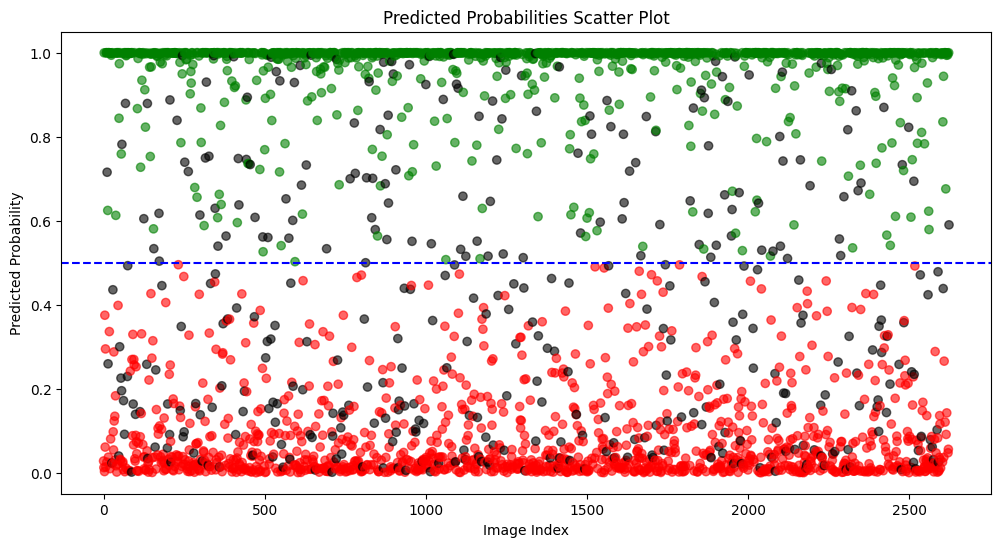

Correct predictions: 2233
Incorrect predictions: 391
Correct predictions for label 0: 1194
Correct predictions for label 1: 1039


In [46]:
plt.figure(figsize=(12, 6))
plt.scatter(x_coords, y_coords, c=colors, alpha=0.6)
plt.title('Predicted Probabilities Scatter Plot')
plt.xlabel('Image Index')
plt.ylabel('Predicted Probability')
plt.axhline(0.5, color='blue', linestyle='--')
plt.show()

# Print the count of correct and incorrect predictions
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {wrong_predictions}")
print(f"Correct predictions for label 0: {c_o}")
print(f"Correct predictions for label 1: {c_l}")


In [56]:
from sklearn.linear_model import LinearRegression


In [57]:
x_coords = np.array(x_coords).reshape(-1, 1)
y_coords = np.array(y_coords)

# Perform linear regression
regressor = LinearRegression()
regressor.fit(x_coords, y_coords)

# Predict values using the linear regression model
y_pred = regressor.predict(x_coords)


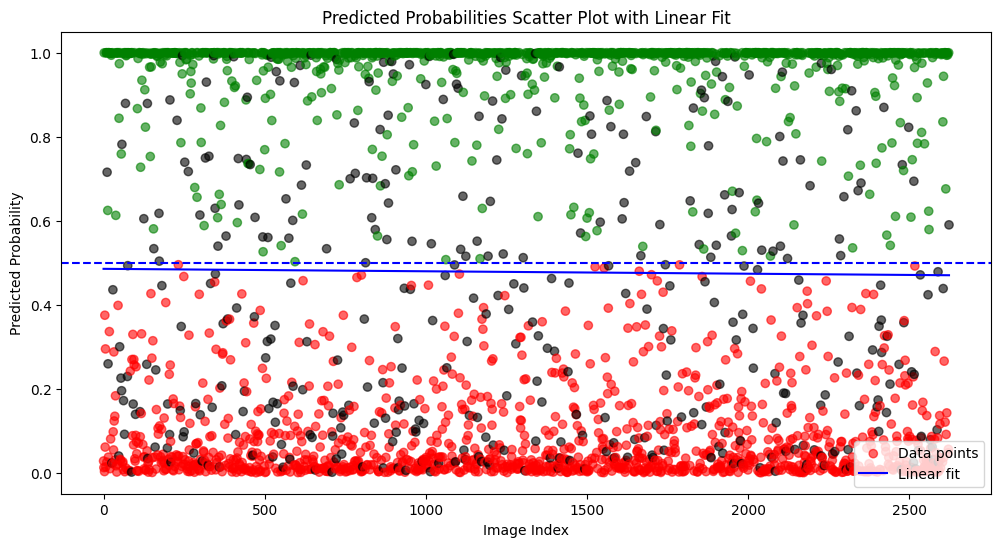

Correct predictions: 2233
Incorrect predictions: 391
Correct predictions for label 0: 1194
Correct predictions for label 1: 1039


In [58]:
plt.figure(figsize=(12, 6))
plt.scatter(x_coords, y_coords, c=colors, alpha=0.6, label='Data points')
plt.plot(x_coords, y_pred, color='blue', label='Linear fit')
plt.title('Predicted Probabilities Scatter Plot with Linear Fit')
plt.xlabel('Image Index')
plt.ylabel('Predicted Probability')
plt.axhline(0.5, color='blue', linestyle='--')
plt.legend()
plt.show()

# Print the count of correct and incorrect predictions
print(f"Correct predictions: {correct_predictions}")
print(f"Incorrect predictions: {wrong_predictions}")
print(f"Correct predictions for label 0: {c_o}")
print(f"Correct predictions for label 1: {c_l}")


In [60]:
# Calculate Sensitivity and Specificity
TPR = c_l / (c_l + (len(ground_truth_labels) * total_batches - c_o))
TNR = c_o / (c_o + (len(ground_truth_labels) * total_batches - c_l))

# Calculate Youden's J statistic
J = TPR + TNR - 1

# Print Youden's J statistic
print(f"Youden's J statistic: {J}")

# Calculate the threshold corresponding to maximal J value
opt_threshold_x = (J + intercept) / slope
print(f"Optimistic Threshold (x-coordinate): {opt_threshold_x}")


Youden's J statistic: -0.14953090142160053
Optimistic Threshold (x-coordinate): -57916.57439139024


In [61]:
# Display the counts of correct and wrong predictions
print("Correct Predictions:", correct_predictions)
print("Wrong Predictions:", wrong_predictions)
print("Predicted True Negatives 0:", c_o)
print("predicted True Positives 1:", c_l)

Correct Predictions: 2233
Wrong Predictions: 391
Predicted True Negatives 0: 1194
predicted True Positives 1: 1039


In [63]:
2233/(2233+391)

0.8509908536585366

In [18]:
model.save("accumodelpp84.h5")

In [47]:
c = 0

In [55]:
print(c)
c += 1

5
